Imports

In [144]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [146]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import os

In [148]:
pip install tensorflow_datasets

In [149]:
import tensorflow_datasets as tfds


Pre Processing Start Here

In [151]:
dataset_list = tfds.list_builders()
print("food101" in dataset_list)

True


In [ ]:
(train_data, test_data) , ds_info = tfds.load(name = "food101",
                                              split=["train","validation"],
                                              shuffle_files = True,
                                              as_supervised= True,
                                              with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
ds_info.features

In [ ]:
class_names = ds_info.features["label"].names
class_names[:10]

In [ ]:
train_one_sample = train_data.take(1)

In [ ]:
train_one_sample

In [ ]:
for image, label in train_one_sample:
    print(f"""
     Image Shape : {image.shape},
     Image Data Type: {image.dtype},
     Target Class from Food101 (tensor form): {label},
     Class name (str form): {class_names[label.numpy()]}
    """)

plt.imshow(image)
plt.axis('off') 
plt.show()

In [14]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

In [15]:
def preprocess_img(image,label,image_shape=224):
    img = tf.image.resize(image, [image_shape,image_shape])
    return tf.cast(img,tf.float32),label

In [16]:
preprocessed_img = preprocess_img(image,label)[0]
print(f"Image Before Preprocessing:\n {image[:2]}...\nShape: {image.shape},...\nDatatype: {image.dtype}\n")
print(f"Image After Preprocessing: \n {preprocessed_img[:2]},...\nShape 0f Preprocessed Image: {preprocessed_img.shape}...\nDatatype of the preprocessed Image: {preprocessed_img.dtype}")

Image Before Preprocessing:
 [[[168 148 123]
  [192 172 147]
  [200 180 155]
  ...
  [179 165 139]
  [188 172 147]
  [154 138 113]]

 [[184 164 139]
  [209 189 164]
  [212 192 167]
  ...
  [207 193 167]
  [218 202 177]
  [184 168 143]]]...
Shape: (512, 512, 3),...
Datatype: <dtype: 'uint8'>

Image After Preprocessing: 
 [[[194.12755 174.12755 149.12755]
  [204.66325 184.66325 159.66325]
  [198.20918 180.42348 158.85204]
  ...
  [200.12253 186.55106 160.97958]
  [204.22949 190.22949 164.22949]
  [195.14168 179.14168 154.14168]]

 [[197.10204 177.10204 150.10204]
  [202.5102  185.5102  159.5102 ]
  [209.96428 193.83673 169.47958]
  ...
  [201.301   187.72952 162.15805]
  [207.8622  193.8622  167.8622 ]
  [197.218   183.218   157.218  ]]],...
Shape 0f Preprocessed Image: (224, 224, 3)...
Datatype of the preprocessed Image: <dtype: 'float32'>


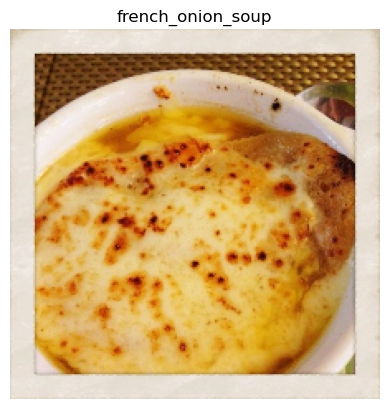

In [17]:
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

In [18]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)



In [19]:
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [20]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

Training Model

In [22]:
checkpoint_path = "model_checkpoints/cp.weights.h5" 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", 
                                                      save_best_only=True, 
                                                      save_weights_only=True, 
                                                      verbose=1)

In [23]:
mixed_precision.set_global_policy(policy="mixed_float16")

In [24]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

In [25]:
input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape)

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-10:]:
    layer.trainable = True

inputs = layers.Input(shape=input_shape, name="input_layer")

x = base_model(inputs, training=True)

x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)

x = layers.Dense(len(class_names), name="dense_layer")(x)

outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

model.summary()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_layer                        │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer (Dense)                  │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 1,022,613 (3.90 MB)

 Non-trainable params: 3,156,339 (12.04 MB)

In [26]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 True float32 <DTypePolicy "mixed_float16">
pooling_layer True float32 <DTypePolicy "mixed_float16">
dense_layer True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


In [27]:
checkpoint_dir = 'model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [28]:
model_checkpoint = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best_model.h5.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

In [29]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop after 5 epochs of no improvement
    restore_best_weights=True,
    verbose=1
)

In [30]:
tensorboard_callback = TensorBoard(
    log_dir='logs',
    histogram_freq=1
)

In [31]:
history = model.fit(
    train_data,   
    epochs=10,
    batch_size=32,
    callbacks=[model_checkpoint, early_stopping, tensorboard_callback]
)

Epoch 1/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4926 - loss: 2.0634

C:\Users\kaust\anaconda3\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
C:\Users\kaust\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 6486s 3s/step - accuracy: 0.4926 - loss: 2.0632
Epoch 2/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 6070s 3s/step - accuracy: 0.6747 - loss: 1.2286
Epoch 3/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 6311s 3s/step - accuracy: 0.7247 - loss: 1.0229
Epoch 4/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 8786s 4s/step - accuracy: 0.7602 - loss: 0.8733
Epoch 5/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 6328s 3s/step - accuracy: 0.7945 - loss: 0.7346
Epoch 6/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 5692s 2s/step - accuracy: 0.8266 - loss: 0.6149
Epoch 7/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 5707s 2s/step - accuracy: 0.8502 - loss: 0.5208
Epoch 8/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 5824s 2s/step - accuracy: 0.8682 - loss: 0.4585
Epoch 9/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 5842s 2s/step - accuracy: 0.8906 - loss: 0.3808
Epoch 10/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 5862s 2s/step - accuracy: 0.9048 - loss: 0.3333


In [62]:
model.save("Food101.h5")

In [65]:
results_fine_tuned_model = model.evaluate(test_data)
results_fine_tuned_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 1221s 2s/step - accuracy: 0.7301 - loss: 1.1148


[1.0996437072753906, 0.7348119020462036]

In [67]:
preds_probs = model.predict(test_data, verbose=1) 

790/790 ━━━━━━━━━━━━━━━━━━━━ 1210s 2s/step


In [69]:
len(test_data)

790

In [71]:
len(preds_probs)

25250

In [73]:
preds_probs.shape

(25250, 101)

In [75]:
preds_probs[:10]

array([[3.95314403e-09, 1.57576139e-08, 1.89673943e-09, ...,
        9.26443317e-05, 6.31710551e-09, 2.95455022e-10],
       [6.34237836e-08, 8.86652708e-01, 2.62727375e-11, ...,
        8.56544835e-10, 2.14559904e-07, 1.46009844e-08],
       [7.79646570e-09, 2.14364082e-10, 1.16302948e-11, ...,
        9.33672127e-05, 3.32013611e-10, 1.91060612e-09],
       ...,
       [2.14657536e-08, 2.57993975e-06, 5.26833395e-12, ...,
        2.31126229e-10, 5.75662341e-07, 1.07483682e-10],
       [1.05005065e-05, 1.50412807e-05, 7.11995235e-05, ...,
        1.11217812e-01, 9.48641809e-06, 1.03020221e-02],
       [7.39927941e-07, 3.33009957e-04, 4.21598202e-07, ...,
        1.65100232e-07, 1.02604933e-01, 1.23654374e-07]], dtype=float32)

In [79]:
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([3.95314403e-09, 1.57576139e-08, 1.89673943e-09, 2.70148366e-08,
        1.05791624e-08, 2.62387829e-07, 4.92123661e-07, 6.07510175e-09,
        1.07489677e-06, 1.19877610e-08, 1.53602620e-09, 5.41144777e-12,
        4.98823596e-08, 4.45399380e-08, 2.58309417e-04, 3.04193545e-11,
        1.95487984e-03, 2.43546161e-09, 7.42773731e-10, 1.86341123e-10,
        5.75179104e-09, 1.20081066e-04, 2.29598772e-05, 1.81369035e-08,
        1.78182169e-09, 4.90943508e-10, 3.89185617e-09, 9.86086501e-09,
        5.57482727e-09, 1.95620596e-05, 7.25567439e-10, 4.57746339e-08,
        1.50903651e-10, 4.50515097e-10, 3.62760910e-09, 6.20610785e-10,
        6.99239910e-09, 1.80988124e-09, 2.10391757e-08, 8.87779061e-06,
        1.29618600e-08, 4.27436797e-09, 1.23682931e-08, 1.65138374e-08,
        6.93798397e-09, 3.86272262e-07, 2.77554285e-10, 4.04689038e-09,
        2.79731155e-10, 7.19921067e-10, 8.50059578e-09, 1.35553857e-09,
        6.31710551e-09, 9.53740420e-10, 4.55689523e-12, 9.557476

In [83]:
print(f"These are the Size of first predictions: {len(preds_probs[0])}")
print(f"These are the predictions of the first: {preds_probs[0]}")
print(f"The maximum value out of the Prediction: {preds_probs[0].argmax()}")

These are the Size of first predictions: 101
These are the predictions of the first: [3.95314403e-09 1.57576139e-08 1.89673943e-09 2.70148366e-08
 1.05791624e-08 2.62387829e-07 4.92123661e-07 6.07510175e-09
 1.07489677e-06 1.19877610e-08 1.53602620e-09 5.41144777e-12
 4.98823596e-08 4.45399380e-08 2.58309417e-04 3.04193545e-11
 1.95487984e-03 2.43546161e-09 7.42773731e-10 1.86341123e-10
 5.75179104e-09 1.20081066e-04 2.29598772e-05 1.81369035e-08
 1.78182169e-09 4.90943508e-10 3.89185617e-09 9.86086501e-09
 5.57482727e-09 1.95620596e-05 7.25567439e-10 4.57746339e-08
 1.50903651e-10 4.50515097e-10 3.62760910e-09 6.20610785e-10
 6.99239910e-09 1.80988124e-09 2.10391757e-08 8.87779061e-06
 1.29618600e-08 4.27436797e-09 1.23682931e-08 1.65138374e-08
 6.93798397e-09 3.86272262e-07 2.77554285e-10 4.04689038e-09
 2.79731155e-10 7.19921067e-10 8.50059578e-09 1.35553857e-09
 6.31710551e-09 9.53740420e-10 4.55689523e-12 9.55747659e-09
 3.70583564e-10 2.43034648e-10 4.20177003e-06 2.18313323e-09


In [87]:
preds_classes = preds_probs.argmax(axis=1)

In [89]:
len(preds_classes)

25250

In [123]:

test_dir = "101_food_data/images"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


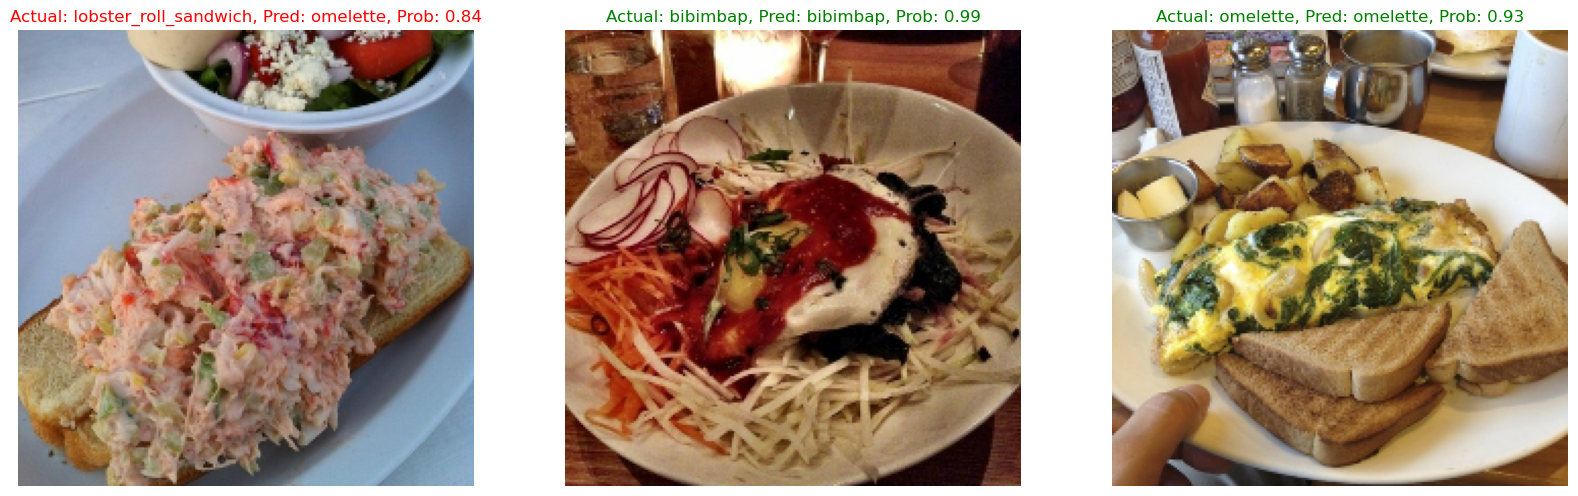

In [140]:
plt.figure(figsize=(20, 10))
for i in range(3):
    # Randomly select a class and an image from that class
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(os.path.join(test_dir, class_name)))
    filepath = os.path.join(test_dir, class_name, filename)

    # Load and preprocess the image
    img = load_and_prep_image(filepath, scale=False)
    img_expanded = tf.expand_dims(img, axis=0)

    # Make predictions
    pred_prob = model.predict(img_expanded)
    pred_class = class_names[pred_prob.argmax()]

    # Plot the image
    plt.subplot(1, 3, i + 1)
    plt.imshow(img / 255.)
    # Set title color based on whether the prediction is correct
    title_color = "g" if class_name == pred_class else "r"
    plt.title(f"Actual: {class_name}, Pred: {pred_class}, Prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False)
plt.show()